# Multi-linear classifier

In this assignment we train and test a one layer network with multi-ple outputs to classify images from the CIFAR-10 dataset. We train the network using mini-batch gradient descent applied to a cost function that computes the cross-entropy loss of the classifier applied to the labelled training data and an L2 regularization term on the weight matrix.

In [2]:
# import functions to load batch, softmax function, compute gradient, display image for each label
# and transfer model to matlab
import functions as functions

import tensorflow.keras.utils as np_utils
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# dir of data
data_batch_1 = "cifar-10-batches-py/data_batch_1"
# validation data
data_batch_2 = "cifar-10-batches-py/data_batch_2"

# Training the multi-linear classifier

We start by extracting the data:

In [10]:
# Reads in the data from a CIFAR-10 batch file 
# Returns the image and label data in separate files.
def LoadBatch(filename):
    data_dict = functions.load_batch(filename)
    data = data_dict[b'data']
    
    # extract the labels
    labels = data_dict[b'labels']
    
    # convert to one-hot representation
    onehot_labels = np_utils.to_categorical(labels)
    
    return data.T, onehot_labels.T, labels

In [11]:
# data is (data_dimension, data_count)
# onehot_labels is (labels_count, data_count)
data, onehot_labels, labels = LoadBatch(data_batch_1)

# we do the same for the validation set
X_validation, Y_validation, labels_validation = LoadBatch(data_batch_2)

data_dimension = len(data[:,0])
labels_count = len(onehot_labels[:,0])

Now we preprocess the raw data by normalizing it (we assume the noise is Gaussian and that the data is normally distributed):

In [12]:
# data is (data_dimension, data_count)
# compute mean and std for each dimension
data_std = np.std(data, axis=1)
data_mean = np.mean(data,axis=1)

validation_std = np.std(X_validation, axis=1)
validation_mean = np.mean(X_validation,axis=1)

# Than normalize the data according to the normal distribution
data = (data - data_mean[:, np.newaxis]) / data_std[:, np.newaxis]

X_validation = (X_validation- validation_mean[:, np.newaxis]) /validation_std[:, np.newaxis]

In [13]:
print("data mean:", np.mean(data))
print("data std:", np.std(data))

print("validation mean:", np.mean(data))
print("validation std:", np.std(data))

data mean: 2.2611542268199023e-18
data std: 0.9999999999999997
validation mean: 2.2611542268199023e-18
validation std: 0.9999999999999997


We have that $$y = \sigma(Wx + b)$$

We know initialize the W and b of the model with each entry have Gaussian random values with zero mean and standard
deviation .01 :

In [14]:
# Define the shape of W
W_shape = (labels_count, data_dimension)
b_shape = (labels_count, 1)

# Initialize the array with Gaussian random values
W = np.random.normal(loc=0.0, scale=0.01, size=W_shape)

b = np.random.normal(loc=0.0, scale=0.01, size=b_shape)

We write the evaluation and cost function:

In [17]:
# returns a (label_count, data_count) matrix
def evaluate_classifier(data, W, b):
    return functions.softmax(np.dot(W, data) + b)

# returns the cost functions that we need to minimize
def compute_cost(data, onehot_labels, W, b, lbd):
    cost = 0
    
    # p is (label_count, data_count)
    p = evaluate_classifier(data, W, b)
    
    # for every data in training data set
    for d in range(0,len(data[0])):
        cost -= np.dot(onehot_labels[:,d].T, np.log(p[:,d]))
        
    # we devide by the data_size    
    cost /= len(data[0])
    
    # we add the regularization term
    cost += lbd * np.sum(W**2)
         
    return cost

In [18]:
compute_cost(data, onehot_labels, W, b, 0)

2.3902248034935156

We write a function that computes the accuracy of the network:

In [31]:
def compute_accuracy(data, labels, W, b):    
    # Get the index of the maximum value which is the label for each row
    predicted_labels = np.argmax(evaluate_classifier(data, W, b), axis=0)
    
    return np.sum(labels == predicted_labels) / len(labels)

We compute the accuracy for the randomly initialized parameters. We should get an accuracy of 10% since it's random and there is 10 labels:

In [32]:
compute_accuracy(data, labels, W, b)

0.1108

We write the function that evaluates for a mini-batch the gradient of the cost function.

The mini-batch gradient is defined as follows: 

$$\textbf{W}^{t+1} = \textbf{W}^t - \eta \sum_{n \in B^t} \nabla l_{cross}(\textbf{x},\textbf{y},\textbf{W},\textbf{b})$$

In [34]:
# mini batch data is (data_dimension, data_size) 
# onehot_labels is (label_count, data_size)
# predicted_labels is (label_count, data_size)
# W is (label_count, data_dimension)
def compute_gradient(data, onehot_labels, predicted_labels, W, lbd):
    data_size = len(data[0])
        
    # g is (label_count, data_size)
    g = -(onehot_labels - predicted_labels)
        
    # add gradient of l(x,y,w,b) w.r.t. W and b:
    Jw = np.dot(g, data.T)/data_size
    Jb = np.mean(g, axis = 1)
    
    # add regularization term
    Jw += 2*lbd*W
        
    return Jw, Jb[:, np.newaxis]

We know check the analytic gradient computations against numerical estimations of the gradients:

In [35]:
# import the compute_grads_num_slow from functions since it uses functions from the notebook
def compute_grads_num_slow(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    # d = X.shape[0]
 
    grad_w = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))
 
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = compute_cost(X, Y, W, b_try, lamda)
 
        b_try = np.array(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, lamda)
 
        grad_b[i] = (c2 - c1) / (2 * h)
 
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w_try = np.array(W)
            w_try[i, j] -= h
            c1 = compute_cost(X, Y, w_try, b, lamda)
 
            w_try = np.array(W)
            w_try[i, j] += h
            c2 = compute_cost(X, Y, w_try, b, lamda)
 
            grad_w[i, j] = (c2 - c1) / (2 * h)
 
    return [grad_w, grad_b]

In [36]:
predicted_labels = evaluate_classifier(data[0:20,0:1], W[:,0:20], b)

grad_W, grad_b = compute_grads_num_slow(X=data[0:20,0:2],
                                        Y=onehot_labels[:,0:2], 
                                        P=predicted_labels[:,0:2], 
                                        W=W[:,0:20], 
                                        b=b, 
                                        lamda=0, 
                                        h=1*-6)
grad_W_a, grad_b_a = compute_gradient(data[0:20,0:1], onehot_labels[:,0:1], predicted_labels[:,0:1], W[:,0:20], lbd=0)

def compute_relative_grad_error(grad_n, grad_a, eps):
    return (abs(grad_n - grad_a) > 1e-6).sum() * 100 /(len(grad_n)*len(grad_n[0]))

Now that we made sure the gradient descent it correct, we implement the mini batch gardient algorithm:

In [37]:
# gd_params = (s_batch, eta, n_epochs)
def mini_batch_gd(data, onehot_labels, gd_params, W, b, lbd, X_validation, Y_validation):
    # define the parameters
    s_batch = gd_params[0]
    eta = gd_params[1]
    n_epochs = gd_params[2]
    
    # initialize empty lists to store the loss and cost function values
    cost = []
    cost_vald = []

    W_star = W
    b_star = b
    
    # construct the mini batches
    mini_batches = construct_mini_batches(s_batch, data, onehot_labels)
    
    validation_mini_batches = construct_mini_batches(s_batch, X_validation, Y_validation)
     
    for iter in range(n_epochs):
        for (mini_batch_X, mini_batch_y) , (mini_batch_x_vald, mini_batch_y_vald) in zip(mini_batches, validation_mini_batches):
            # compute the predictions for the mini_batch
            predicted_labels = evaluate_classifier(mini_batch_X, W_star, b_star)

            # compute the new gradients
            grad_w, grad_b = compute_gradient(mini_batch_X, mini_batch_y, predicted_labels, W_star, lbd)        
            W_star = W_star - eta * grad_w
            b_star = b_star - eta * grad_b

        # compute the loss and cost function values
        cost.append(compute_cost(mini_batch_X, mini_batch_y, W_star, b_star,lbd))
        cost_vald.append(compute_cost(mini_batch_x_vald, mini_batch_y_vald, W_star, b_star, lbd))
        
    plot_loss_cost(cost, cost_vald)
    return W_star, b_star
    
# return a tuple of arrays (x_batch, y_batch)
def construct_mini_batches(s_batch, data, onehot_labels):
    nb_batch = int(np.ceil(len(data[0])/s_batch))
    
    mini_batches = []
    
    for j in range(nb_batch):
        # set the start and end index of the batch
        j_start = j*s_batch
        j_end = (j+1)*s_batch        
        x_batch = data[:,j_start:j_end]
        y_batch = onehot_labels[:,j_start:j_end]
        
        mini_batches.append((x_batch, y_batch))
        
    return mini_batches

# plot the cost function values after each epoch
def plot_loss_cost(cost, cost_vald):
    plt.plot(cost, label='Train Cost')
    plt.plot(cost_vald, label='Validation Cost')
    plt.xlabel('n_epochs')
    plt.ylabel('cost')
    plt.legend()
    plt.show()

We run the code:

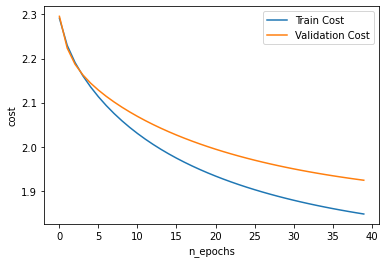

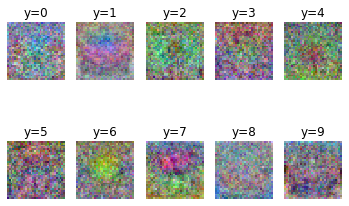

0.3865

In [38]:
gd_params = (100, 0.001, 40)
lbd = 0.1
W_star, b_star = mini_batch_gd(data, onehot_labels, gd_params, W, b, lbd, X_validation, Y_validation)

functions.montage(W_star)
compute_accuracy(X_validation, labels_validation, W_star, b_star)